In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score

import matplotlib.pyplot as plt
%matplotlib inline

# Generate some data for the tutorial
This is the Hypercube problem with 10 features, where the first 5 features are relevant.

In [2]:
from sklearn.datasets import make_classification

n_features = 10

X, y = make_classification(n_samples=400, n_features=n_features, n_informative=5, n_redundant=0, shuffle=False, random_state=123)

# The five first features are truly relevant
indices_relevant_features = np.zeros(10)
indices_relevant_features[:5] = 1

Divide into training, validation and test sets

In [3]:
# (XLS, yLS) = training set
XLS, X_tmp, yLS, y_tmp = train_test_split(X, y, train_size=200, random_state=123, stratify=y)

# (XVS, yVS) = validation set
# (XTS, yTS) = test set
XVS, XTS, yVS, yTS = train_test_split(X_tmp, y_tmp, train_size=100, random_state=123, stratify=y_tmp)

# PRS (Parametric Random Subspace)

### Input arguments of `PRS`:

**PRS**(*XLS, yLS, XVS, yVS, estimator, estimator_kwargs, isClassification, normalize_data=True, XTS=None,
        alphas_init=None, lambda_reg=0, nmodels=100, batch_size=None, train_size=None,
        nepochs=3000, learning_rate=0.001, rho1=0.9, rho2=0.999,
        variance_reduction=True, random_seed=100*)
          

**XLS**: Array of shape (n_samples_LS, n_features). Training input samples.

**yLS**: Array of shape (n_samples_LS,). Training output samples.

**XVS**: Array of shape (n_samples_VS, n_features). Validation input samples.

**yVS**: Array of shape (n_samples_VS,). Validation output samples.

**estimator**: scikit-learn learner class (type of base learner).

**estimator_kwargs**: dictionary containing the hyper-parameters of the estimator. The dictionary does not need to contain all the hyper-parameter values. When a hyper-parameter is missing from the dictionary, it is set to the default value used by scikit-learn.

**isClassification**: Boolean indicating if this is a classification problem or not (otherwise it is a regression problem).

**normalize_data**: Boolean indicating if input data must be normalized. default=_True_

**XTS**: Array of shape (n_samples_TS, n_features). Test input samples. default=_None_

**alphas_init**: Array of shape (n_features,), *float* or *None*. Initial values of the feature selection probabilities alphas. If *float*, all alphas are initialised at that value. If *None*, all alphas are initialized to 5/nmodels. default=_None_

**lambda_reg**: *float*. Value of the regularisation coefficient (hyper-parameter *lambda* in the paper). default=0.0

**nmodels**: *int*. Number of base models in the PRS ensemble. default=100

**batch_size**: *int* or *None*. Number of samples in each mini-batch. If *None*, the mini-batch size is set to 10% of the training set size. default=_None_

**train_size**: *int* or *None*.  Number of samples used to train each base model. If *None*, train_size = original training set size - batch_size. default=_None_

**nepochs**: *int*. Number of epochs of the training algorithm. default=3000

**learning_rate**: *float*. Learning rate of the Adam algorithm. default=0.001

**rho1**: *float*. Hyper-parameter rho1 of the Adam algorithm. default=0.9

**rho2**: *float*. Hyper-parameter rho2 of the Adam algorithm. default=0.999

**variance_reduction**: Boolean indicating whether or not to apply the variance reduction technique with baseline. default=_True_

**random_seed**: *int*. Random seed. default=100


### Output of `PRS`:
Tuple *(alphas, objective_values_LS, objective_values_VS, train_indices, yVSpred, yTSpred)*.

**alphas**: Array of shape (n_features,). Trained alphas values.

**objective_values_LS**: Array of shape (nepochs+1,). Values of the objective function at each epoch on the learning set.

**objective_values_VS**: Array of shape (nepochs+1,). Values of the objective function at each epoch on the validation set.

**train_indices**: Indices of the epochs where new models were learned.

**yVSpred**: Array of shape (n_samples_VS, ). Predictions of the trained PRS model on the validation set.

**yTSpred**: Array of shape (n_samples_TS, ). Predictions of the trained PRS model on the test set. yTSpred=numpy.nan if XTS is None.


In [4]:
# Base learner = kNN with default hyper-parameters
from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier
estimator_kwargs = dict()

from PRS import PRS

# The number of epochs is set here to 100 to speed up the tutorial,
# but this hyper-parameter should be higher in practice
alphas, objective_values_LS, objective_values_VS, train_indices, yVSpred, yTSpred = PRS(XLS, yLS,
                                                                                        XVS, yVS,
                                                                                        estimator, estimator_kwargs,
                                                                                        XTS=XTS, isClassification=True,
                                                                                        nmodels=100,
                                                                                        nepochs=100)

# Accuracy on test set
print('Test accuracy = %.3f' % accuracy_score(yTS, yTSpred))

# Average number of features selected per base model
print('Average subspace size: %.2f' % np.sum(alphas))

Test accuracy = 0.880
Average subspace size: 3.16


### Plot objective function value across epochs

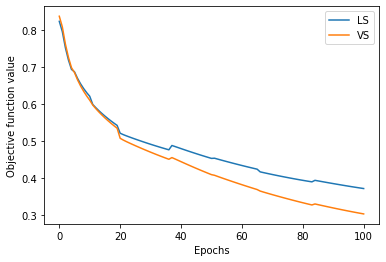

In [5]:
plt.plot(objective_values_LS, label='LS')
plt.plot(objective_values_VS, label='VS')
plt.xlabel('Epochs')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

### Alphas (feature importances)

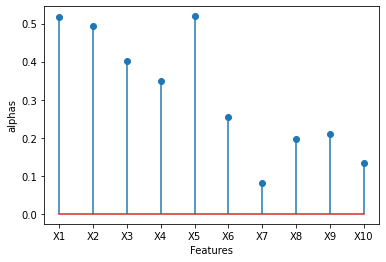

Feature ranking AUPR = 1.000


In [6]:
# Plot alphas
plt.stem(alphas, use_line_collection=True)
plt.xticks(np.arange(n_features), ['X%d' % i for i in range(1, n_features+1)])
plt.xlabel('Features')
plt.ylabel('alphas')
plt.show()

# AUPR of feature ranking
AUPR = average_precision_score(indices_relevant_features, alphas)
print('Feature ranking AUPR = %.3f' % AUPR)

# Baseline methods

In [7]:
from baselines import RF, GBDT, RS

### Random forest

Best hyper-parameter K: 3
Test accuracy = 0.930
Feature ranking AUPR = 1.000


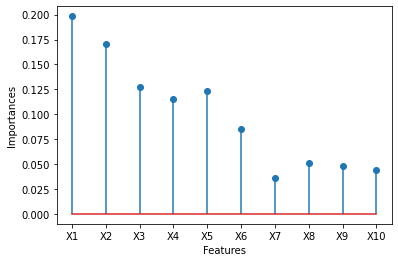

In [8]:
selected_K, yTSpred, feat_importances = RF(XLS, yLS, XVS, yVS, XTS,
                                           isClassification=True,
                                           nmodels=100, normalize_data=True)

# Number of features randomly sampled at each test node, optimized on the validation set
print('Best hyper-parameter K: %d' % selected_K)

# Accuracy on test set
print('Test accuracy = %.3f' % accuracy_score(yTS, yTSpred))

# AUPR of feature ranking
AUPR = average_precision_score(indices_relevant_features, feat_importances)
print('Feature ranking AUPR = %.3f' % AUPR)

# Plot feature importances
plt.stem(feat_importances, use_line_collection=True)
plt.xticks(np.arange(n_features), ['X%d' % i for i in range(1, n_features+1)])
plt.xlabel('Features')
plt.ylabel('Importances')
plt.show()

### Gradient boosting decision trees

Best hyper-parameter max_depth: 7
Test accuracy = 0.920
Feature ranking AUPR = 0.943


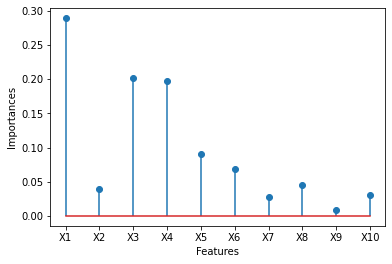

In [9]:
selected_max_depth, yTSpred, feat_importances = GBDT(XLS, yLS, XVS, yVS, XTS,
                                                     isClassification=True,
                                                     nmodels=100, normalize_data=True)

# Maximum tree depth, optimized on the validation set
print('Best hyper-parameter max_depth: %d' % selected_max_depth)

# Accuracy on test set
print('Test accuracy = %.3f' % accuracy_score(yTS, yTSpred))

# AUPR of feature ranking
AUPR = average_precision_score(indices_relevant_features, feat_importances)
print('Feature ranking AUPR = %.3f' % AUPR)

# Plot feature importances
plt.stem(feat_importances, use_line_collection=True)
plt.xticks(np.arange(n_features), ['X%d' % i for i in range(1, n_features+1)])
plt.xlabel('Features')
plt.ylabel('Importances')
plt.show()

### Random subspace

In [10]:
# Base learner = kNN with default hyper-parameters
from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier
estimator_kwargs = dict()
    
selected_K, yTSpred = RS(XLS, yLS, XVS, yVS, XTS,
                         estimator, estimator_kwargs,
                         isClassification=True, nmodels=100, normalize_data=True)

# Number of features randomly sampled for each base model, optimized on the validation set
print('Best subspace size: %d' % selected_K)

# Accuracy on test set
print('Test accuracy = %.3f' % accuracy_score(yTS, yTSpred))

Best subspace size: 3
Test accuracy = 0.890


# RaSE

**rase**(*XLS, yLS, XVS, yVS, estimator, estimator_kwargs, isClassification, nmodels=100, B=500, D=None, niterations=10, C0=0.1, XTS=None, normalize_data=True, tune_decision_cutoff=False, random_seed=100, nthreads=1*)
              
### Input arguments of `rase`:

**XLS**: Array of shape (n_samples_LS, n_features). Training input samples.

**yLS**: Array of shape (n_samples_LS,). Training output samples.

**XVS**: Array of shape (n_samples_VS, n_features). Validation input samples.

**yVS**: Array of shape (n_samples_VS,). Validation output samples.

**estimator**: scikit-learn learner class (type of base learner).

**estimator_kwargs**: dictionary containing the hyper-parameters of the estimator. The dictionary does not need to contain all the hyper-parameter values. When a hyper-parameter is missing from the dictionary, it is set to the default value used by scikit-learn.

**isClassification**: Boolean indicating if this is a classification problem or not (otherwise it is a regression problem).

**nmodels**: *int*. Number of base models in the ensemble. default=100

**B**: *int*. Number of subspace candidates generated for each base model. default=500

**D**: *int*. Maximal subspace size when generating random subspaces. If None, D is set to min(sqrt(n_samples_LS), nfeatures). default=_None_

**niterations**: *int*. Number of iterations. default=10

**C0**: *float*. Positive constant used to set the minimum feature selection probability. default=0.1

**XTS**: Array of shape (n_samples_TS, n_features). Test input samples. default=_None_

**normalize_data**: Boolean indicating if input data must be normalized. default=_True_**

**tune_decision_cutoff**: Boolean indicating if the decision cutoff must be tuned like in the original RaSE method (only for classification). default=_False_

**random_seed**: *int*. Random seed. default=100

**nthreads**: *int*. Number of threads used for parallel computing. default=1

### Output of `rase`:
Tuple *(feat_importances, feat_subset_sizes, yTSpred)*.

**feat_importances**: Array of shape (n_features,). Feature importances.

**feat_subset_sizes**: Array of shape (nmodels,). Number of sampled features for each base model.

**yTSpred**: Array of shape (n_samples_TS, ). Predictions of the of the trained PRS model on the test set. yTSpred=numpy.nan if XTS is None.


In [11]:
# Base learner = kNN with default hyper-parameters
from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier
estimator_kwargs = dict()

from rase import rase

# The input arguments nmodels and B are set to small values here to speed up the tutorial,
# but should be increased in practice
feat_importances, feat_subset_sizes, yTSpred = rase(XLS, yLS, XVS, yVS, estimator, estimator_kwargs, XTS=XTS,
                                                    isClassification=True, nmodels=10, B=50,
                                                    niterations=3, normalize_data=True,
                                                    tune_decision_cutoff=False)

# Accuracy on test set
print('Test accuracy = %.3f' % accuracy_score(yTS, yTSpred))

# Average subspace size
print('Average subspace size: %.2f' % np.mean(feat_subset_sizes))

Test accuracy = 0.900
Average subspace size: 6.10


### Feature importances

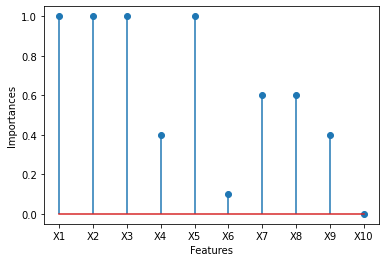

Feature ranking AUPR = 0.925


In [12]:
# Plot feature importances
plt.stem(feat_importances, use_line_collection=True)
plt.xticks(np.arange(n_features), ['X%d' % i for i in range(1, n_features+1)])
plt.xlabel('Features')
plt.ylabel('Importances')
plt.show()

# AUPR of feature ranking
AUPR = average_precision_score(indices_relevant_features, feat_importances)
print('Feature ranking AUPR = %.3f' % AUPR)